In [1]:
!git pull
#!python3 create_npy_files.py

Already up to date.


In [125]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [126]:
if torch.cuda.is_available():
    print("Cuda available")
    device = torch.device('cuda:0')
else:
    device = "cpu"

Cuda available


In [127]:
# Loading data
# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

def load_data(data_dir):
    X_train = np.load(data_dir)
    print(f"Shape of training data: {X_train.shape}")
    print(f"Data type: {type(X_train)}")
    print(type(X_train[0][0][0][0]))
    return X_train

# Create numpy arrays from npy files
X_train_cage = load_data('cage.npy')
X_train_trump = load_data('trump.npy')

# Convert to range [0, 1]
X_train_cage /= 255
X_train_trump /= 255

# Create array with both cage and trump images
X_train_cage_trump = np.append(X_train_cage, X_train_trump, axis=0)

# Normalize to make training easier
# means = np.mean(X_train_trump, axis=(0, 1, 2))
# print(mean)

# X_train_cage_trump -= means
# X_train_cage -= means
# X_train_trump -= means

X_train_cage = X_train_cage.astype(np.float32)
X_train_trump = X_train_trump.astype(np.float32)
X_train_cage_trump = X_train_cage.astype(np.float32)

X_train_cage = torch.from_numpy(X_train_cage)
X_train_trump = torch.from_numpy(X_train_trump)
X_train_cage_trump = torch.from_numpy(X_train_cage_trump)

X_train_cage = X_train_cage.to(device)
X_train_trump = X_train_trump.to(device)

Shape of training data: (4178, 64, 64, 3)
Data type: <class 'numpy.ndarray'>
<class 'numpy.float64'>
Shape of training data: (9864, 64, 64, 3)
Data type: <class 'numpy.ndarray'>
<class 'numpy.float64'>


In [128]:
#Remove trump images
np.random.seed(1337)
np.random.shuffle(X_train_trump)
X_train_trump = X_train_trump[:4200]
print(X_train_trump.shape)
print(X_train_cage.shape)

torch.Size([4200, 64, 64, 3])
torch.Size([4178, 64, 64, 3])


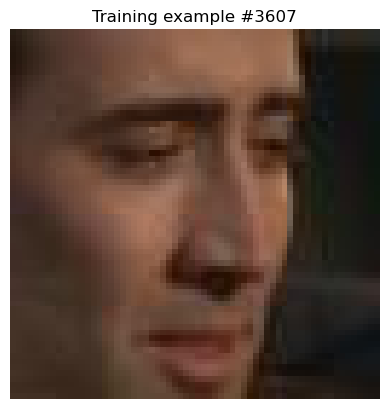

In [19]:
# Display random image of cage for testing purposes
random_image = random.randint(0, len(X_train_cage) - 1)
img = X_train_cage[random_image].cpu()
plt.imshow(img)
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

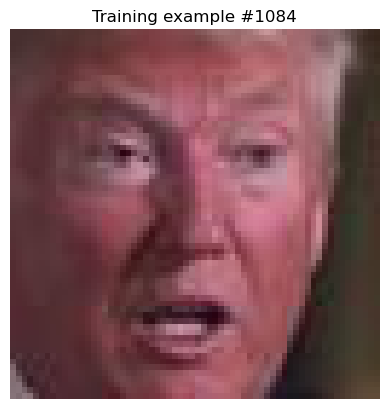

In [20]:
# Display random image of trump for testing purposes
random_image = random.randint(0, len(X_train_trump) - 1)
img = X_train_trump[random_image].cpu()
plt.imshow(img)
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

In [129]:
class CustomImageDataset(Dataset):
    def __init__(self, X, transforms=None):
      self.X = X
      self.transforms = transforms
        
    def __len__(self):
      return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        if self.transforms is not None:
            image = image.permute(2, 0, 1)
            image = self.transforms(image)
            image = image.permute(1, 2, 0)
        return image

In [130]:
batch_size = 64

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=(-9, 9), interpolation=transforms.functional.InterpolationMode.BILINEAR),
    #transforms.Normalize(mean=means, std=[1.0, 1.0, 1.0]),
])


# norm_transform = transforms.Normalize(mean=means, std=stds)
cage_dataset = CustomImageDataset(X_train_cage, transforms=transform)
cage_dl = DataLoader(cage_dataset, batch_size, shuffle=True)

trump_dataset = CustomImageDataset(X_train_trump, transforms=transform)
trump_dl = DataLoader(trump_dataset, batch_size, shuffle=True)

#cage_trump_dataset = CustomImageDataset(X_train_cage_trump)
#cage_trump_dl = DataLoader(cage_trump_dataset, batch_size, shuffle=True)

torch.Size([64, 64, 3])


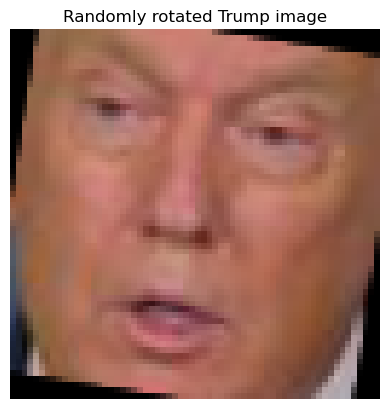

torch.Size([64, 64, 3])


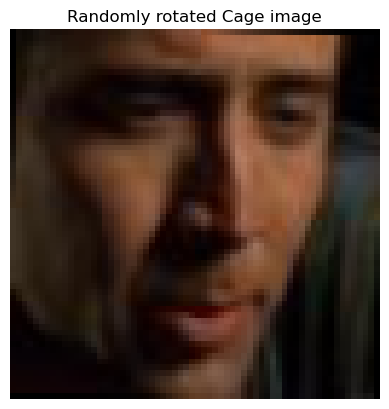

In [131]:
trump_img = next(iter(trump_dl))[0].cpu()
print(trump_img.shape)
plt.imshow(trump_img)
plt.title(f"Randomly rotated Trump image")
plt.axis('off')
plt.show()

cage_img = next(iter(cage_dl))[0].cpu()
print(cage_img.shape)
plt.imshow(cage_img)
plt.title(f"Randomly rotated Cage image")
plt.axis('off')
plt.show()

In [132]:
class BasicAE(nn.Module):
    def __init__(self):
        super(BasicAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 1024, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Flatten(),
            nn.Linear(4 * 4 * 1024, 1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(1024, 4 * 4 * 1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Unflatten(1, (1024, 4, 4)),
            nn.Conv2d(1024, 512 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
        )
        self.decoder_cage = nn.Sequential(
            nn.Conv2d(512, 256 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(256, 128 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(128, 64 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 3, 5, padding=2),
            nn.Sigmoid(),
        )
        self.decoder_trump = nn.Sequential(
            nn.Conv2d(512, 256 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(256, 128 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(128, 64 * 4, 3, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 3, 5, padding=2),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        x = x.permute(0, 3, 1, 2)
        if y == 0:
            x = self.encoder(x)
            # print(x.shape)
            x = self.decoder_cage(x)
            # print(x.shape)
        else:
            x = self.encoder(x)
            x = self.decoder_trump(x)
        x = x.permute(0, 2, 3, 1)
        return x

In [435]:
ae = BasicAE().to(device)
# ae = torch.load("100_new_dataset.pth")
# ae.eval()
for X in cage_dl:
    res = ae(X,0)
    break

In [150]:
learning_rate = 3e-5
epochs = 50

loss_fn = nn.L1Loss()
#optimizer_1 = torch.optim.Adam([{'params': ae.encoder.parameters()},
                          #{'params': ae.decoder_cage.parameters()}], lr=learning_rate, betas=(0.4, 0.999))
#optimizer_2 = torch.optim.Adam([{'params': ae.encoder.parameters()},
                          #{'params': ae.decoder_trump.parameters()}], lr=learning_rate, betas=(0.4, 0.999))
    
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate, betas=(0.4, 0.999))

In [151]:
def train_loop(dataloader_cage, dataloader_trump, model, loss_fn, optimizer, X_train_cage, X_train_trump):
    cage_iterator = iter(dataloader_cage)
    trump_iterator = iter(dataloader_trump)
    while True:
        try:
            cage_batch = next(cage_iterator)
            trump_batch = next(trump_iterator)
        except StopIteration:
            return loss_1.item(), loss_2.item(), loss.item()
        #Forward
        cage_out = model(cage_batch, 0)
        trump_out = model(trump_batch, 1)

        loss_1 = loss_fn(cage_out, cage_batch)
        loss_2 = loss_fn(trump_out, trump_batch)
        loss = loss_1 + loss_2
        
        #Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [152]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_cage, loss_trump, tot_loss = train_loop(cage_dl, trump_dl, ae, loss_fn, optimizer, X_train_cage, X_train_trump)
    print(f"Cage loss: {loss_cage:>7f}, Trump loss: {loss_trump:>7f}, Total loss: {tot_loss:>7f}")
print("Done!")

Epoch 1
-------------------------------
Cage loss: 0.020456, Trump loss: 0.019909, Total loss: 0.040365
Epoch 2
-------------------------------
Cage loss: 0.022043, Trump loss: 0.020383, Total loss: 0.042427
Epoch 3
-------------------------------
Cage loss: 0.020934, Trump loss: 0.020947, Total loss: 0.041881
Epoch 4
-------------------------------
Cage loss: 0.020389, Trump loss: 0.020161, Total loss: 0.040550
Epoch 5
-------------------------------
Cage loss: 0.021752, Trump loss: 0.019637, Total loss: 0.041389
Epoch 6
-------------------------------
Cage loss: 0.019921, Trump loss: 0.019422, Total loss: 0.039343
Epoch 7
-------------------------------
Cage loss: 0.020084, Trump loss: 0.019238, Total loss: 0.039321
Epoch 8
-------------------------------
Cage loss: 0.020357, Trump loss: 0.020252, Total loss: 0.040609
Epoch 9
-------------------------------
Cage loss: 0.020036, Trump loss: 0.019941, Total loss: 0.039977
Epoch 10
-------------------------------
Cage loss: 0.020602, Tr

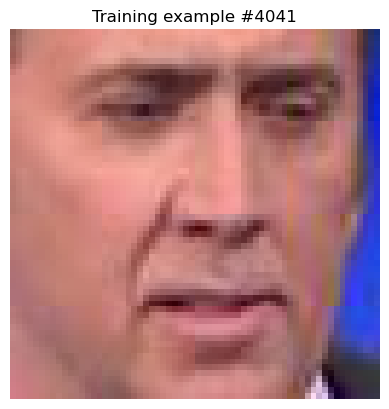

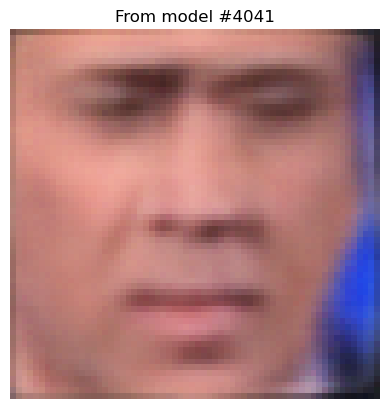

In [440]:
# Test cage to cage
# Display random image of cage
random_image = random.randint(0, len(X_train_cage) - 1)
img = X_train_cage[random_image]
# img += torch.from_numpy(means).to(device)
img_tensor = img.unsqueeze(0)
res = ae(img_tensor, 0)
res = res[0]
res = res.cpu().detach().numpy()
plt.imshow(img.cpu())
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

plt.imshow(res)
plt.title(f"From model #{random_image}")
plt.axis('off')
plt.show()

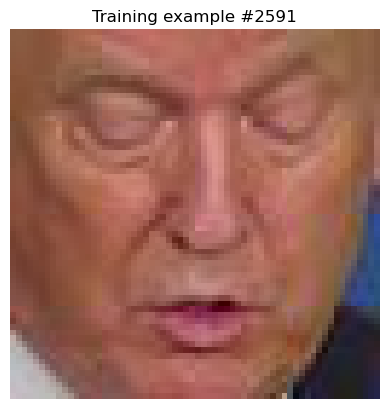

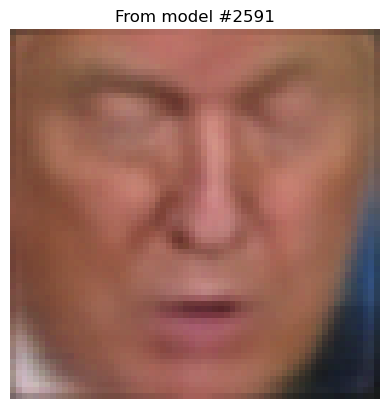

In [442]:
# Test trump to trump
# Display random image of cage
random_image = random.randint(0, len(X_train_trump) - 1)
img = X_train_trump[random_image]
# img += torch.from_numpy(means).to(device)
img_tensor = img.unsqueeze(0)
res = ae(img_tensor, 1)
res = res[0]
res = res.cpu().detach().numpy()
plt.imshow(img.cpu())
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

plt.imshow(res)
plt.title(f"From model #{random_image}")
plt.axis('off')
plt.show()

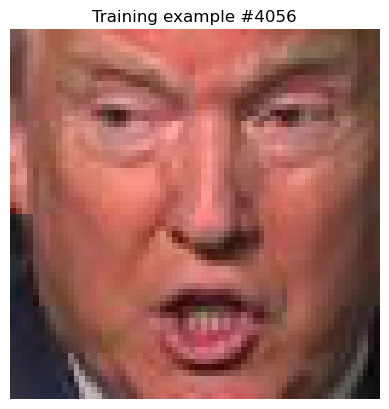

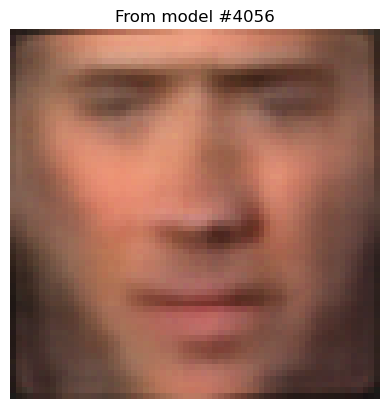

In [451]:
# Test trump to cage
# Display random image of cage
random_image = random.randint(0, len(X_train_trump) - 1)
img = X_train_trump[random_image]
# img += torch.from_numpy(means).to(device)
img_tensor = img.unsqueeze(0)
res = ae(img_tensor, 0)
res = res[0]
res = res.cpu().detach().numpy()
plt.imshow(img.cpu())
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

plt.imshow(res)
plt.title(f"From model #{random_image}")
plt.axis('off')
plt.show()

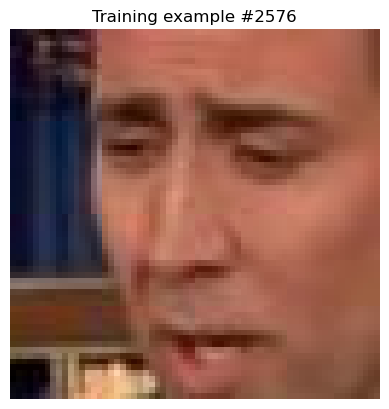

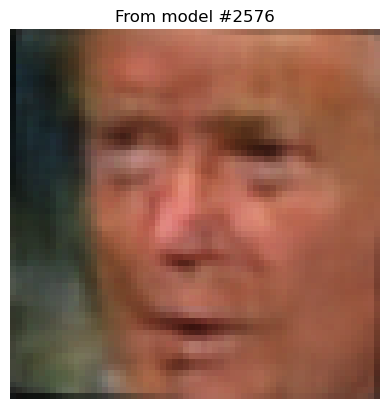

In [389]:
# Test cage to trump
# Display random image of cage
random_image = random.randint(0, len(X_train_cage) - 1)
img = X_train_cage[random_image]
# img += torch.from_numpy(means).to(device)
img_tensor = img.unsqueeze(0)
res = ae(img_tensor, 1)
res = res[0]
res = res.cpu().detach().numpy()
plt.imshow(img.cpu())
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

plt.imshow(res)
plt.title(f"From model #{random_image}")
plt.axis('off')
plt.show()

In [165]:
torch.save(ae, "model.pth")

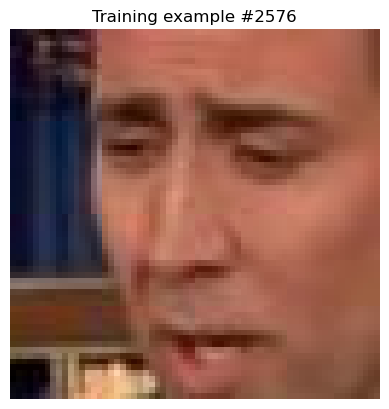

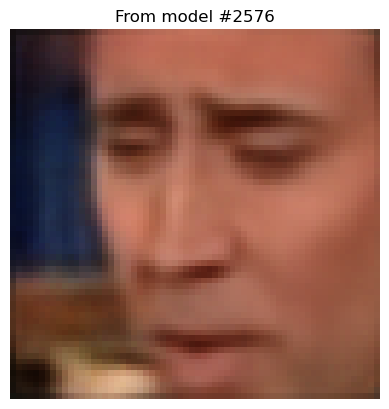

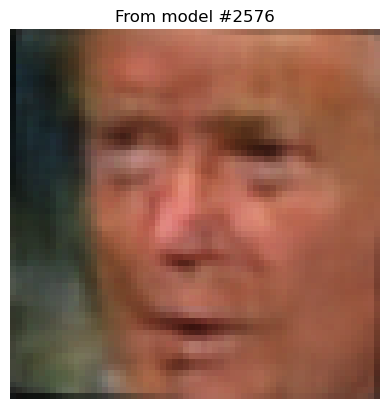

In [390]:
from PIL import Image

def save_img(person, index, save_dir):
    if person == "trump":
        img = X_train_trump[index]
    else:
        img = X_train_cage[index]
    img_tensor = img.unsqueeze(0)
    res_cage = ae(img_tensor, 0)
    res_cage = res_cage[0]
    res_cage = res_cage.cpu().detach().numpy()
    res_trump = ae(img_tensor, 1)
    res_trump = res_trump[0]
    res_trump = res_trump.cpu().detach().numpy()
    res_trump = res_trump * 255
    res_trump = res_trump.astype(np.uint8)
    res_trump = Image.fromarray(res_trump)
    res_cage = res_cage * 255
    res_cage = res_cage.astype(np.uint8)
    res_cage = Image.fromarray(res_cage)
    img = img.cpu().detach().numpy()
    img = img * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    
    if person == "trump":
        img.save(save_dir + person + str(index) + ".jpg")
        res_trump.save(save_dir + person + str(index) + "_1.jpg")
        res_cage.save(save_dir + person + str(index) + "_2.jpg")
    else:
        img.save(save_dir + person + str(index) + ".jpg")
        res_cage.save(save_dir + person + str(index) + "_1.jpg")
        res_trump.save(save_dir + person + str(index) + "_2.jpg")
    
    plt.imshow(img)
    plt.title(f"Training example #{index}")
    plt.axis('off')
    plt.show()

    plt.imshow(res_cage)
    plt.title(f"From model #{index}")
    plt.axis('off')
    plt.show()
    
    plt.imshow(res_trump)
    plt.title(f"From model #{index}")
    plt.axis('off')
    plt.show()

save_img("cage", 2576, "./results/")